# Intro

Supervised ML focuses on prediction, but it is actions that influence the world. Predictions can be useful inputs into decision-making, but decision-making involves a subsequent optimization step which we currently devote less energy to.

Reinforcement learning (RL) directly optimizes actions. But RL research is focused on very different problems than those where supervised ML is providing value today. This notebook shows a decision optimization workflow designed for mainstream business applications. 

My interactions with data scientists outside the tech giants convince me that this approach will add at least as much value as businesses have received from adopting supervised ML so far.

The workflow is:
1. Encode a practitioners domain knowledge into a model. This model can be a system of multiple equations, depicting different moving parts of the business environment.
2. Use existing data to estimate parameters of the relationships described in the model. More detail on this below.
3. Treat the estimated model as a simulation environment. Optimize the decision policy in this simulation environment.
4. Apply that decision policy in the real business environment

### Differences from Conventional RL

This approach differs from mainstream RL in 3 ways:

1. The RL community generally eschews human engineered models. I go the opposite direction, relying on human knowledge to structure the model.

2. RL research is computationally difficult because it is applied to problems with high dimensional state spaces (e.g. robotics and video games). I focus on problems where state spaces are several orders of magnitude smaller. Optimization is much easier in such low dimensional spaces.

3. Conventional RL agents learn by interacting directly with the environment. But no business would deploy an untrained agent to experiment with important business decisions. Instead, I do optimization offline (in the simulator). Only the optimized policy would be deployed to a real environment.

> Though I use a model, this workflow is not conventional model-based reinforcement learning. Specifically, the model of the environment isn't updated during policy optimization. This difference flows from the goal of doing policy optimization outside the real environment.
This approach is closer to [World Models](https://arxiv.org/abs/1803.10122). But World Models avoids human knowledge when building the simulator, relying instead on standard deep learning models. My approach would fail in the World Models testbed (a video game) because humans have little intuition in the pixel space. But humans have good intuitions about the problems I aim to solve, and that knowledge is a beneficial regularizer in my proposed workflow.

# Example: Airline Pricing
Airlines already use machine learning models to help set ticket prices. The ML model predicts how many tickets the airline can sell each day for each upcoming flight for each candidate price. The models consider price, seasonablity, competitor prices, macroeconomic variables, etc. But even a perfect predictive model doesn't guarantee efficient price setting.

For example, consider a flight happening in 100 days with 150 unsold seats. A predictive model says you can sell 1 ticket today for \\$300 or you could sell 2 tickets if you set the price at $250. Which price should you choose? 

Airlines currently convert predictive models into pricing decisions with shockingly simple heuristics (e.g. a table of how many tickets to sell at pre-specified periods before the flight)

This notebook trains an agent to set prices through a more formal and flexible optimization process. 

To illustrate the how resulting pricing policies perform in the original data generating environment, I use a simulation for the data generating process rather than using real data. Though I take a fixed dataset for trainng the predictive model in the conventional way. 

For illustrative simplicity, this example considers a market with only two airlines. I train an agent to set prices for Jetblue, facing a competitor called Delta.

### The Two Models

I use two models:
The **structural model** defines the parts of the market that a domain expert can specify. The structural model used in this example is straightforward.  It is implemented in this code [This code](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/market.py#L45).

The key facts encoded in the model are:

Each flight starts with a fixed number of available seats and a fixed number of days to departure. 

Each day until the flight happens
- airlines can update the ticket price daily
- the number of seats available decreases by the number of seats that airline sells
- the number of days until the flight decreases by 1
- accumulated revenue for the flight increases by `ticket_price * seats_sold`
- airlines cannot sell more seats than the plane has, and sales stop when the plane takes off (this model ignores overbooking, though someone more knowledgeable might add it to the model)


The second model is the **predictive model**, which captures things the airline is uncertain about:
- How their competitor sets prices
- How many seats each airline will sell on each day (as a function of daily demand shocks and each airline's price)

I start by conventional [deep learning model](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/keras_models.py#L22) for the predictive model. Towards the end of the notebook I use a Bayesian neural network for the predictive model and discuss the resulting benefits.

The structural model is completely deterministic once it receives the predictions from the predictive model.

> Aside: The field of structural econometrics has historically incorporated all uncertainty into the structural model, and not used a separate predictive model. This requires specifying functional forms in the structural model and estimating those parameters directly (e.g. with maximum likelihood estimation). That workflow has the standard shorcomings of GLM style modeling (e.g. underfitting). Abstracting uncertainty into a predictive model provides the flexibility to use modern ML.

### Implementation Details
The code captures the two models in two objects:
- A `CompetitiveConditions` object contains the predictive model. It captures pricing strategies and the process for determining how many tickets are sold. When generating training data, the `CompetitiveConditions` object holds the true data generating process for pricing and quantity determination (rather than a predictive model). The data generating is unlike the predictive models that approximate it. Details of the data generating process for price and quantity determination aren't central to my workflow, so their description is saved for the end of this notebook.

- A `Market` object contains the logic for the structural model. The `market` object takes `CompetitiveConditions` as an argument, so predictions about market dynamics can be plugged into the structural model.

`Market` follows the OpenAI Gym API, allowing standard RL libraries to be used for pricing policy optimization in our model based environment.

# Step 1: Collect Data From Real Market

I define parameters and import a pricing function for use in the true data generating process. The exact market mechanisms (which the constants below affect) aren't central to explaining my modeling and optimization approach. So the description of market mechanics is postponed to the bottom of this notebook.

For now, you can treat the quantity-determining mechanism and it's parameters as a black box, much as the airlines do.

In [1]:
import numpy as np
import pandas as pd

from matplotlib import style
style.use('fivethirtyeight')

from sem_policy_opt.true_dgp import get_true_qty_demanded_fn

# Constants hidden from airlines
CUSTOMER_LEVEL_RANDOMNESS = 20 # Std. Dev of idiosyncratic custom preference between airlines
DEMAND_SIGNAL_NOISINESS = 20  # Std. Dev of noise in how airlines' obversve daily traffic shocks
MAX_DEMAND_LEVEL = 400 # The most any customer will ever pay
POTENTIAL_CUSTOMERS_PER_DAY = 20 # Number of unique agents on consumer side of data generating process
FLIGHTS_IN_TRAINING_DATA = 250
FLIGHTS_IN_VAL_DATA = 25

# Constants known to airlines
SEATS_PER_FLIGHT = 250 
SALES_WINDOW_LENGTH = 120 # Length of time airline has to sell tickets before flight takes off

I used trial and error to find a reasonable pricing function. I use the following function for both airlines when creating "real" data.

In [2]:
def simple_price_fn(my_demand_signal, days_before_flight, my_seats_avail, competitor_full): 
    # Charge more if you have a lot of time to sell seats, if few seats are available, or if you have little competition
    # On net, prices may increase over time because low seat inventory overwhelms remaining time effect.
    formula_price = 50 + my_demand_signal + 0.6 * days_before_flight - my_seats_avail + 40 * int(competitor_full)
    # demand_signal is noisy and can thus be negative. Never price tickets below some price_floor
    price_floor = 10
    actual_price = max(formula_price, price_floor)
    return actual_price


# Step 1: Collect Training Data from Real Market

Airlines have historical data they can use to build a model. Here, I run the "real" environment to create training data.

In [3]:
from sem_policy_opt.market import Market
from sem_policy_opt.market_conditions import CompetitiveConditions
from sem_policy_opt.diagnostics import run_env

real_market_conditions = CompetitiveConditions(delta_price_fn = simple_price_fn, 
                                               qty_fn=get_true_qty_demanded_fn(POTENTIAL_CUSTOMERS_PER_DAY, CUSTOMER_LEVEL_RANDOMNESS))

real_market = Market(real_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH) 

train_profits, train_data = run_env(real_market, simple_price_fn, n_times=FLIGHTS_IN_TRAINING_DATA)
val_profits, val_data = run_env(real_market, simple_price_fn, n_times=FLIGHTS_IN_VAL_DATA)

# Step 2: Fit Predictive Model on Real Data

We use the training data to fit a model that predicts Delta's price and both airlines' quantity sold as a function of
- Days remaining
- Jetblue's demand signal
- Jetblue's remaining number of seats available
- Whether Delta's flight is fully booked (i.e. whether Delta is still selling tickets)


In [4]:
import pymc3 as pm
from sem_policy_opt.pymc_models import WrappedPymcModel
from sem_policy_opt.keras_models import WrappedKerasModel
from sem_policy_opt.diagnostics import r_squared
import theano
from theano import tensor as tt

predictive_model = WrappedKerasModel(train_data)

print('r-squared values for predictive model:')
r_squared(predictive_model, val_data.iloc[:200])

r-squared values for predictive model:


{'delta_price': 0.83, 'jb_qty_sold': 0.45, 'delta_qty_sold': 0.41}

# Step 3: Set Up Model-Based Market Simulator

I create a market based not on the true data generating processes (which the Jetblue doesn't know), but instead based on the predictive model.

In [5]:
sim_market_conditions = CompetitiveConditions(predictive_model=predictive_model)
sim_market = Market(sim_market_conditions, MAX_DEMAND_LEVEL, DEMAND_SIGNAL_NOISINESS, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)


As a diagnostic, I compare predicted profits from using Jetblue's current pricing function in the training, validation and simulator data.

In [6]:
simple_price_sim_profits, simple_price_sim_data = run_env(sim_market, simple_price_fn, n_times=20)

print("Mean profits in training data: ${:,.0f} \n"
      "Mean profits in val data: ${:,.0f} \n"
      "Mean profits in sim data: ${:,.0f} \n".format(train_profits.mean(), val_profits.mean(), simple_price_sim_profits.mean()))

Mean profits in training data: $41,293 
Mean profits in val data: $42,018 
Mean profits in sim data: $44,164 



### Step 3.1 Model Diagnostics
This modeling set-up facilitates the types of diagnostics common in classical econometrics or Bayesian modeling. Beyond one example, I omit those in this notebook to move on to optimization. 

As an example, we can plot a demand curve and cross-price demand curve. These show how predicted ticket sales vary with respect to Jetblue's prices (holding other factors constant.)

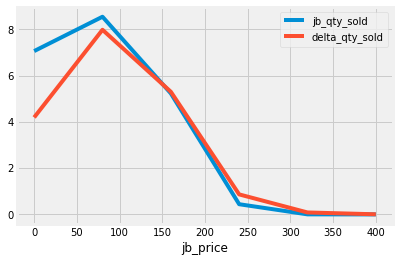

In [7]:
demand_curves = pd.DataFrame()
for jb_price in np.linspace(0, MAX_DEMAND_LEVEL, 10):
    prediction_data = pd.DataFrame(dict(days_before_flight=[150], 
                                        jb_demand_signal=[150], 
                                        delta_price=[150],
                                        jb_price=[jb_price]))
    prediction = predictive_model.predict(prediction_data)
    prediction['jb_price'] = [jb_price]
    demand_curves = pd.concat([demand_curves, pd.DataFrame(prediction)])
demand_curves.plot(x='jb_price', y=['jb_qty_sold', 'delta_qty_sold'])

Non-monotonicities show shortcomings of the predictive model. We would interate on the model in practical applications, but pricing policy optimization works well even with this model.

# Step 4: Optimize Policy Function
We could use an arbitrary optimization procedure to optimize our policy. The appendix contains a Soft Actor Critic optimizer, and I may experiment with other optimizers in the future. For now, I use a simple grid search. Pricing policies are created as linear functions of the state variables
- Daily demand signal
- Days remaining before flight
- Seats available
- Whether the competitor's flight is full

I try various multipliers of these state variables. The pricing equation is specified more precisely [here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/diagnostics.py#L9).

The optimization code is below.

In [8]:
from collections import OrderedDict
from itertools import product
from time import time
from sem_policy_opt.diagnostics import pricing_fn_creator, get_real_and_sim_rewards

optim_start_time = time()

# Create points in grid of pricing policies to be considered during optimization
intercepts = np.linspace(0, 200, 4)
demand_signal_mults = np.linspace(0, 1, 4)
days_before_flight_mults = np.linspace(0, 1, 3)
seats_avail_mults = np.linspace(-1, 0, 3)
competitor_full_mults = np.linspace(0, 100, 3)
price_floors = np.linspace(10, 50, 2)

pricing_combinations = product(intercepts, demand_signal_mults, days_before_flight_mults, 
                               seats_avail_mults, competitor_full_mults, price_floors)

pricing_fns = [pricing_fn_creator(*params) for params in pricing_combinations]
real_and_sim_rewards = get_real_and_sim_rewards(real_market, sim_market, pricing_fns)

print("Optimation time: {}".format(int(time()-optim_start_time)))

Optimation time: 1174


A firm would select the policy that returns the highest predicted profit in simulation (since simulation is all they can see before implementing a new policy). This process is effective to the extent the policy generates higher profits in the true market environment. Predicted and real profits from various policies are shown in the following graph.

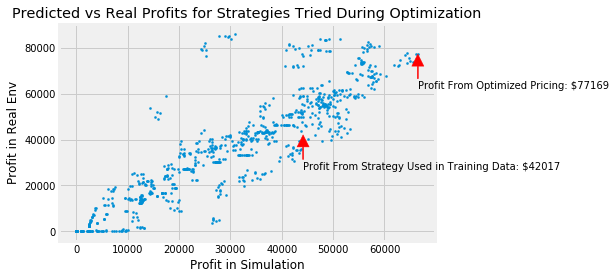

In [9]:
from sem_policy_opt.diagnostics import plot_optim_results

plot_optim_results(real_and_sim_rewards,
                   baseline_real_profits=val_profits.mean(), 
                   baseline_sim_profits=simple_price_sim_profits.mean())

# Sensitivity Analysis

The optimization process appears effective. Did this hinge critically on the quality of the predictive model?

The firm predicts demand each day from a "demand signal", and we have a variable that specifies how noisy these signals are.

The following test varies the amount of noise in the demand signal. This in turn varies the quality of the predictive model (i.e. as measured with r-squared). The result shows the relationship between quality of the predictive model and effectiveness of policy optimization.

---

noise level: 20
r_squared values: {'delta_price': 0.86, 'jb_qty_sold': 0.51, 'delta_qty_sold': 0.48}


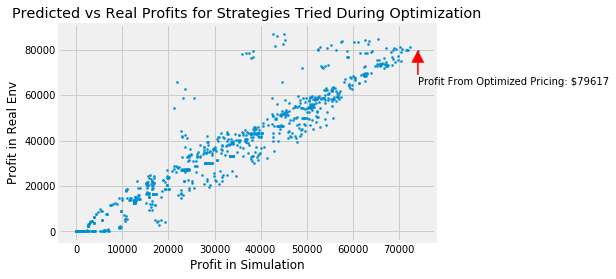

---

noise level: 50
r_squared values: {'delta_price': 0.56, 'jb_qty_sold': 0.36, 'delta_qty_sold': 0.26}


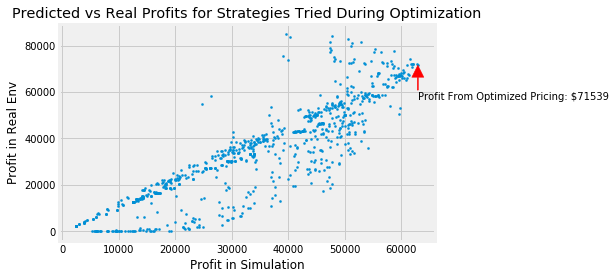

---

noise level: 100
r_squared values: {'delta_price': 0.21, 'jb_qty_sold': 0.27, 'delta_qty_sold': 0.13}


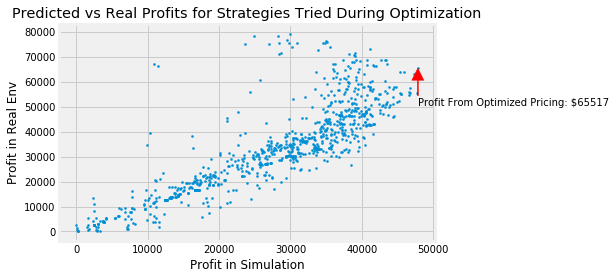

,noise_level,own_qty_r_squared,competitor_qty_r_squared,baseline_profits,real_profits,best_sim_profits,best_possible_real_profits
0,20,0.51,0.48,42485,79617,74066,87009
1,50,0.36,0.26,37286,71539,62950,85084
2,100,0.27,0.13,30521,65517,47836,79359


In [14]:
from sem_policy_opt.diagnostics import sensitivity_analysis

noisy_real_market_maker = lambda demand_noisiness: Market(real_market_conditions, MAX_DEMAND_LEVEL, demand_noisiness, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)
noisy_sim_market_maker = lambda demand_noisiness, sim_conditions: Market(sim_conditions, MAX_DEMAND_LEVEL, demand_noisiness, SEATS_PER_FLIGHT, SALES_WINDOW_LENGTH)

sensitivity_results = sensitivity_analysis(noisy_real_market_maker, 
                                           noisy_sim_market_maker, 
                                           noise_levels = [20, 50, 100],
                                           pricing_fns=pricing_fns,
                                           model_class=WrappedKerasModel,
                                           flights_in_training_data = FLIGHTS_IN_TRAINING_DATA,
                                           baseline_price_fn=simple_price_fn)
sensitivity_results

Real profits from policy optimization decrease as the environment gets noisier (and the model gets worse). This is due to worsening optimization (and not a change in the best possible policy), as the real profits from a perfectly chosen policy remain high.

Optimization beats the baseline in all circumstances, though this may be an unfair comparison as the baseline policy was chosen from ad-hoc experimentation when the baseline noise level was 20.

Fortunately, simulated profits are close to real profits in all cases. So a firm would have a reasonable estimate of real profits before deploying any policy.

### Bayesian Deep Learning: Uniquely Well Suited for Decision Optimization

Here I use Bayesian deep learning for the predictive model. The model architecture [defined here](https://github.com/dansbecker/sem_policy_opt/blob/master/sem_policy_opt/pymc_models.py#L16) is simpler than the keras model I've used thus far.

Using a Bayesian model will allow optimization over the model posterior (i.e. sampling from the posterior on weights in the deep learning model). This should lead to better policies, especially when:

1) The environment has important non-linearities / convexities (think Jensen's inquality)
2) The environment is noisy
3) The training data is small (in terms of number of rows)

The way I sample from this distribution is currently hacky in a way that could affect the results. I aim to fix this, so won't write out a detailed description here. Nevertheless, I show preliminary results from the current form of sampling on the Bayesian NN predictive model.

Average Loss = 1.2382e+05: 100%|██████████| 15000/15000 [01:52<00:00, 133.46it/s]
Finished [100%]: Average Loss = 1.238e+05


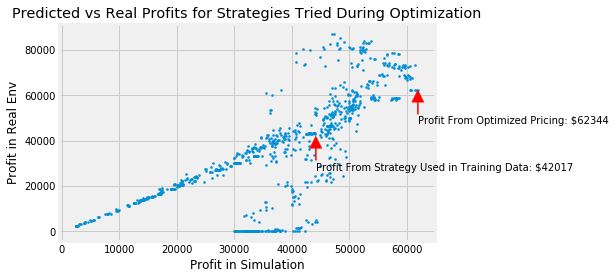

Optimation time: 32414


In [15]:
bayesian_predictive_model = WrappedPymcModel(train_data)

bayesian_sim_market_conditions = CompetitiveConditions(predictive_model=bayesian_predictive_model)
bayesian_sim_market = Market(bayesian_sim_market_conditions, 
                             MAX_DEMAND_LEVEL, 
                             DEMAND_SIGNAL_NOISINESS, 
                             SEATS_PER_FLIGHT, 
                             SALES_WINDOW_LENGTH)

bayesian_simulator_results = get_real_and_sim_rewards(real_market,
                                                      bayesian_sim_market,
                                                      pricing_fns)

plot_optim_results(bayesian_simulator_results,
                   baseline_real_profits=val_profits.mean(),
                   baseline_sim_profits=simple_price_sim_profits.mean())

print("Optimation time: {}".format(int(time()-optim_start_time)))

# Next Steps

My planned next steps are

1. Clean up sampling with a Bayesian predictive modeling
2. Abstract out the logic that's universal vs use-case specific
3. This notebook optimizes in the simulator by a grid search. This will scale poorly as the state space gets larger. Re-enable the code to do optimization through the [stable_baselines](https://github.com/hill-a/stable-baselines) implementation of standard RL algorithms. Their appear to be idiosyncasies to installing this library in Kaggle kernels.
4. Run on real (static) dataset rather than synthetic dataset to illustrate this workflow

# Current Concerns
Price optimization nearly doubled real profits in the main example. This is robust to the amount of noise in the model. But I see three primary objections to this example:

1) This improvement is over a baseline I created through trial and error, not a policy used in the real world (I certainly don't mean to suggest that a Fortune 500 company could double revenue this easily).

2) This example is a somewhat simple problem: there are only two airlines and we didn't account for factors like seasonality. It would be straightforward to include these factors in the model, though I've yet to show how well the process works in a more complex environment.

3) Most concerning, it's unclear how to show that a policy created through optimization will work well without applying it (there's nothing like a test set from supervised ML).

I think these concerns can be addressed. Moreover, I think this workflow can have as big an impact in the next 10 years as what enterprise adoption of supervised ML has had in the last 10 years.

# Appendix

### Optimization Through Modern Reinforcement Learning

The cell below optimizes the pricing policy with Soft Actor Critic (SAC), an RL algorithm that is sample efficient and which is reported to require little hyperparameter tuning.

NOTE: I am sharing this notebook output in Kaggle Kernels. I've not yet been able to install `stable_baselines` in kernels, so I've commented this part out for now. The value of my underlying approach doesn't hinge on whether I do optimization through SAC, grid search (used above) or something else

In [12]:
if False:    # disabled until I install stable_baselines in Kernels
    from stable_baselines.common.vec_env import DummyVecEnv
    from stable_baselines.sac.policies import MlpPolicy
    from stable_baselines.sac import SAC
    from time import time
    import os

    sim_market_maker = lambda: market_maker(sim_market_conditions)
    
    parallelism_level = 1         # use os.cpu_count() if not using SAC. SAC doesn't allow parallelism
    env = DummyVecEnv([sim_market_maker for _ in range(parallelism_level)]) # Env is vectorized market for parallelism
    total_learning_steps = 750000
    steps_per_update = 10000
    optim_results = []

    model = SAC(MlpPolicy, env)

    start_time = time()
    for step in range(0, total_learning_steps+1, steps_per_update):
        model.learn(total_timesteps=steps_per_update)
    
        mean_sim_reward = run_env(sim_market_maker, model, n_times=5)[0].mean()
        mean_real_reward = run_env(real_market_maker, model, n_times=5)[0].mean()
        optim_results.append(dict(step=step, 
                                  time=time()-start_time,
                                  sim_profit=mean_sim_reward,
                                  real_profit=mean_real_reward))
    
        print("""{} timesteps used for learning in {:.0f} seconds. 
                 Current score in sim: {:.0f}. Current score in real market: {:.0f}.""".format(
                                                                                step,
                                                                                time()-start_time, 
                                                                                mean_sim_reward, 
                                                                                mean_real_reward))
    optim_results_df = pd.DataFrame(optim_results)
    optim_results_df.plot.line(x='step', y=['sim_profit', 'real_profit'])